<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

DataFrames on a Cluster
=======================

<img src="http://www.numfocus.org/uploads/6/0/6/9/60696727/6893890_orig.png"
     align="left"
     width="30%"
     alt="Pandas logo">


### Read single dataframe from S3 with Pandas

In [1]:
from s3fs import S3FileSystem

s3 = S3FileSystem()
s3.ls('dask-data/nyc-taxi/2015/')

['dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-02.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-03.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-04.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-05.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-06.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-07.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-08.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-09.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-10.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-11.csv',
 'dask-data/nyc-taxi/2015/yellow_tripdata_2015-12.csv']

In [2]:
with s3.open('dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv') as f:
    print(f.read(1000))

b'VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount\r\n2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896484375,40.750110626220703,1,N,-73.974784851074219,40.750617980957031,1,12,1,0.5,3.25,0,0.3,17.05\r\n1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.00164794921875,40.7242431640625,1,N,-73.994415283203125,40.759109497070313,1,14.5,0.5,0.5,2,0,0.3,17.8\r\n1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963340759277344,40.802787780761719,1,N,-73.951820373535156,40.824413299560547,2,9.5,0.5,0.5,0,0,0.3,10.8\r\n1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,.50,-74.009086608886719,40.713817596435547,1,N,-74.004325866699219,40.719985961914063,2,3.5,0.5,0.5,0,0,0.3,4.8\r\n1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176147460938,40.7624282

In [3]:
import pandas as pd

with s3.open('dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv') as f:
    df = pd.read_csv(f, nrows=5, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0,0.3,16.30


### Parallelize Pandas with Dask.dataframe


In [3]:
from dask.distributed import Executor, progress
e = Executor('127.0.0.1:8786')
e

<Executor: scheduler=127.0.0.1:8786 processes=1 cores=8>

In [4]:
import dask
dask.set_options(get=e.get)  # use distributed cluster by default

In [5]:
import dask.dataframe as dd
df = dd.read_csv('s3://dask-data/nyc-taxi/2015/*.csv', 
                 parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [6]:
df = e.persist(df)
progress(df)


Dask DataFrames
---------------

*  Coordinate many Pandas DataFrames across a cluster
*  Faithfully implement a subset of the Pandas API
*  Use Pandas under the hood (for speed and maturity)

In [8]:
df

dd.DataFrame<from-de..., npartitions=688>

In [9]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount\r                  float64
dtype: object

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [11]:
%time len(df)

CPU times: user 237 ms, sys: 27.8 ms, total: 265 ms
Wall time: 22.7 s


146112989

In [12]:
%time df.passenger_count.sum().compute()

CPU times: user 82.6 ms, sys: 4.36 ms, total: 87 ms
Wall time: 475 ms


245566747

In [13]:
# Compute average trip distance grouped by passenger count
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0     2.279183
1    15.541413
2    11.815871
3     1.620052
4     7.481066
5     3.066019
6     2.977158
7     3.303054
8     3.866298
9     5.459763
Name: trip_distance, dtype: float64

### Tip Fraction, grouped by day-of-week and hour-of-day

In [14]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]
df2 = df2.assign(tip_fraction=df2.tip_amount / df2.fare_amount)

In [15]:
# Group df.tpep_pickup_datetime by dayofweek and hour
dayofweek = df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = e.persist([dayofweek, hour])
progress(dayofweek, hour)

In [16]:
dayofweek.compute()

tpep_pickup_datetime
0    0.247436
1    0.245873
2    0.245531
3    0.256465
4    0.253445
5    0.244604
6    0.273651
Name: tip_fraction, dtype: float64

In [17]:
hour.compute()

tpep_pickup_datetime
0     0.279146
1     0.297799
2     0.316710
3     0.302988
4     0.386847
5     0.266719
6     0.244143
7     0.223922
8     0.229207
9     0.224865
10    0.234477
11    0.240881
12    0.234556
13    0.245949
14    0.248464
15    0.239672
16    0.245523
17    0.251433
18    0.246901
19    0.282979
20    0.244501
21    0.251308
22    0.253288
23    0.256635
Name: tip_fraction, dtype: float64

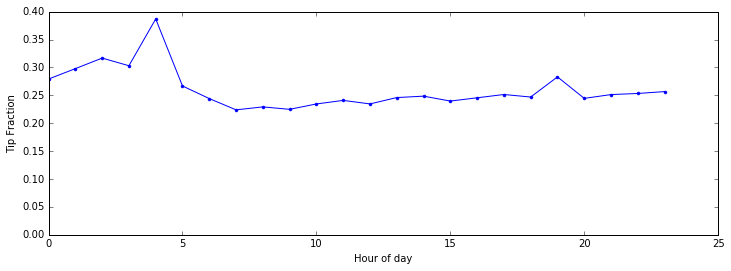

In [18]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(hour.compute().values, '.-')
plt.ylim(ymin=0);
plt.xlabel("Hour of day")
plt.ylabel("Tip Fraction")